In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/dodkins/PythonProjects/stocks/options_testing/options_testing')

import os
from datetime import datetime 
import pandas as pd
import opstrat as op

from robinhood import get_options_plays
from yahoo import get_tsla 
from plots import plot_candles, plot_line, plot
from strategies import get_option_history, weekly_short_calls, LEAPS
from utils import aggregate
from quantconnect import load_tsla_hourly

/Users/dodkins/.conda/envs/stocks/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
filename = '../data/CalmFluorescentOrangeBee.txt'

In [16]:
with open(filename) as f:
    lines = f.readlines()

In [25]:
l = 0
line = lines[l]
while 'Algorithm finished warming up' not in line:
    l += 1
    line = lines[l]
    print(line, l)
lines = lines[l+1:]

2022-03-25 00:00:00 Warning: The following securities were set to raw price normalization mode to work with options: TSLA...
 1
2022-03-25 00:00:00 Algorithm starting warm up...
 2
2022-03-29 10:00:00 Algorithm finished warming up.
 3


In [30]:
l = -1
line = lines[l]
while 'completed in' not in line:
    l -= 1
    line = lines[l]
    print(line, l)
lines = lines[:l]

In [31]:
lines

['2022-04-06 10:00:00 TSLA  220414C01035000,Bid=41.7 Ask=42.4 Last=42.65 OI=498.0 sigma=0.744 NPV=62.784                             delta=0.564 gamma=0.003 vega=74.819 beta=17.35 theta=-2.29 IV=0.47\n',
 '2022-04-06 10:00:00 TSLA  220414C01040000,Bid=38.95 Ask=39.5 Last=39.22 OI=466.0 sigma=0.744 NPV=60.270                             delta=0.550 gamma=0.003 vega=75.201 beta=16.95 theta=-2.30 IV=0.46\n',
 '2022-04-06 10:00:00 TSLA  220414C01045000,Bid=36.2 Ask=36.75 Last=36.7 OI=374.0 sigma=0.744 NPV=57.826                             delta=0.536 gamma=0.003 vega=75.487 beta=16.55 theta=-2.31 IV=0.46\n',
 '2022-04-06 10:00:00 TSLA  220414C01050000,Bid=33.6 Ask=34.1 Last=34.01 OI=2204.0 sigma=0.744 NPV=55.454                             delta=0.521 gamma=0.003 vega=75.678 beta=16.14 theta=-2.31 IV=0.46\n',
 '2022-04-06 10:00:00 TSLA  220414C01055000,Bid=31.15 Ask=31.6 Last=31.5 OI=354.0 sigma=0.744 NPV=53.151                             delta=0.507 gamma=0.003 vega=75.774 beta=15.73 th

In [118]:
columns=['date', 'Bid', 'Ask', 'Last', 'OI', 'sigma', 'NPV', 
             'delta', 'gamma', 'vega', 'beta', 'theta', 'IV']

In [150]:
df = pd.DataFrame(
    index=range(len(lines)),
    dtype=float
)

In [109]:
datetime.strptime(f'{s[0]} {s[1]}', '%Y-%m-%d %H:%M:%S')

datetime.datetime(2022, 4, 6, 10, 0)

In [110]:
col_locs = np.zeros(len(columns))
words = line.split(' ')
for iw, word in enumerate(words):
    for ic, col in enumerate(columns):
        if col in word:
            col_locs[ic] = iw

In [111]:
col_locs

array([ 0.,  4.,  5.,  6.,  7.,  8.,  9., 38., 39., 40., 41., 42., 43.])

In [157]:
for l, line in enumerate(lines):
    words = line.split(' ')
    df.at[l,'date'] = datetime.strptime(f'{words[0]} {words[1]}', '%Y-%m-%d %H:%M:%S')
    for ic, col in enumerate(columns[1:], start=1):
        df.at[l, col] = float(words[int(col_locs[ic])].split('=')[-1].split('\n')[0])
        # print(col, float(words[int(col_locs[ic])].split('=')[-1].split('\n')[0])**2)

In [158]:
df

,date,Bid,Ask,Last,OI,sigma,NPV,delta,gamma,vega,beta,theta,IV
0,2022-04-06 10:00:00,41.70,42.40,42.65,498.0,0.744,62.784,0.564,0.003,74.819,17.35,-2.29,0.47
1,2022-04-06 10:00:00,38.95,39.50,39.22,466.0,0.744,60.270,0.550,0.003,75.201,16.95,-2.30,0.46
2,2022-04-06 10:00:00,36.20,36.75,36.70,374.0,0.744,57.826,0.536,0.003,75.487,16.55,-2.31,0.46
3,2022-04-06 10:00:00,33.60,34.10,34.01,2204.0,0.744,55.454,0.521,0.003,75.678,16.14,-2.31,0.46
4,2022-04-06 10:00:00,31.15,31.60,31.50,354.0,0.744,53.151,0.507,0.003,75.774,15.73,-2.32,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,2022-04-12 16:00:00,29.55,30.75,30.20,952.0,0.669,46.814,-0.589,0.005,49.222,-9.31,-2.63,0.32
630,2022-04-12 16:00:00,33.15,34.50,33.98,628.0,0.669,49.978,-0.611,0.005,48.512,-9.63,-2.59,0.32
631,2022-04-12 16:00:00,37.05,38.45,38.00,1143.0,0.669,53.249,-0.633,0.004,47.652,-9.93,-2.55,0.32
632,2022-04-12 16:00:00,41.15,42.65,42.28,1861.0,0.669,56.623,-0.654,0.004,46.666,-10.21,-2.50,0.32


In [162]:
df['delta'].dtype, df['date'].dtype

(dtype('float64'), dtype('<M8[ns]'))

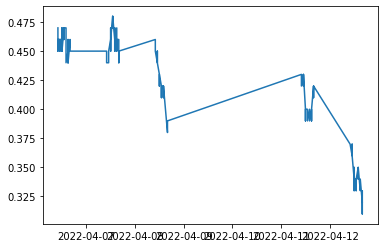

In [164]:
plt.plot(df['date'], df['IV'])

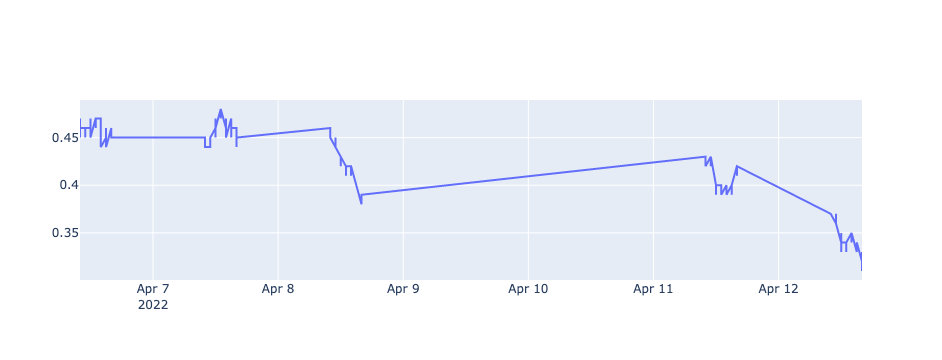

In [169]:
plot_line(df, value='IV', show_afterhours=True)

In [176]:
df.iloc[-50:]

,date,Bid,Ask,Last,OI,sigma,NPV,delta,gamma,vega,beta,theta,IV
584,2022-04-12 14:00:00,23.05,23.65,23.63,1244.0,0.669,39.241,0.567,0.005,49.950,8.58,-2.69,0.35
585,2022-04-12 14:00:00,12.60,12.80,12.60,4022.0,0.669,28.685,-0.433,0.005,49.951,-7.02,-2.67,0.35
586,2022-04-12 15:00:00,18.55,18.95,18.80,1244.0,0.669,35.539,0.535,0.005,50.118,8.07,-2.70,0.33
587,2022-04-12 15:00:00,16.00,16.30,16.30,1250.0,0.669,33.093,0.512,0.005,50.293,7.73,-2.71,0.33
588,2022-04-12 15:00:00,13.60,13.90,13.80,1916.0,0.669,30.765,0.488,0.005,50.292,7.39,-2.71,0.33
589,2022-04-12 15:00:00,11.60,11.80,11.70,1279.0,0.669,28.553,0.465,0.005,50.118,7.05,-2.70,0.33
590,2022-04-12 15:00:00,9.70,9.95,9.80,9048.0,0.669,26.457,0.442,0.005,49.775,6.71,-2.68,0.33
591,2022-04-12 15:00:00,6.75,6.95,6.92,1655.0,0.669,22.602,0.396,0.005,48.607,6.04,-2.62,0.33
592,2022-04-12 15:00:00,5.60,5.75,5.80,730.0,0.669,20.837,0.374,0.004,47.798,5.71,-2.58,0.33
593,2022-04-12 15:00:00,4.60,4.80,4.70,2859.0,0.669,19.179,0.353,0.004,46.853,5.39,-2.54,0.33


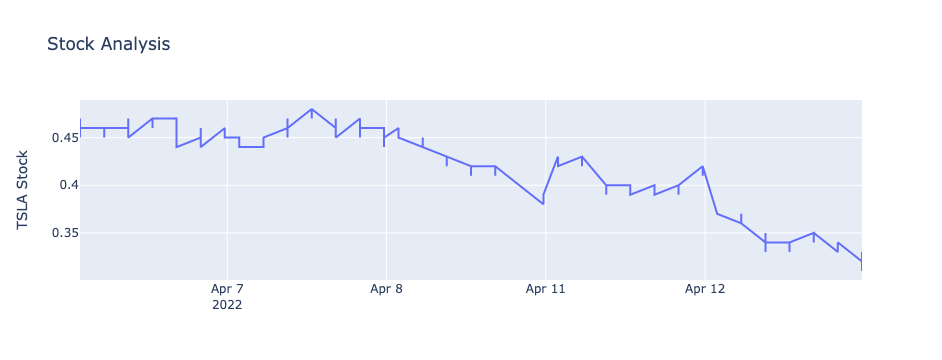

In [168]:
plot_line(df, value='IV', show_afterhours=False)

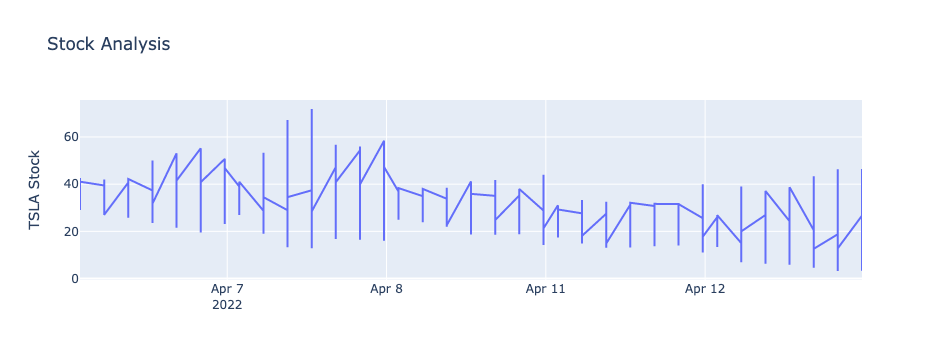

In [177]:
plot_line(df, value='Last', show_afterhours=False)

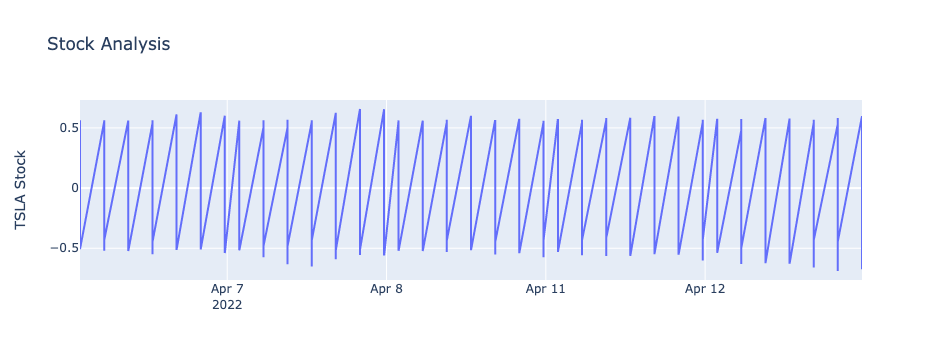

In [178]:
plot_line(df, value='delta', show_afterhours=False)

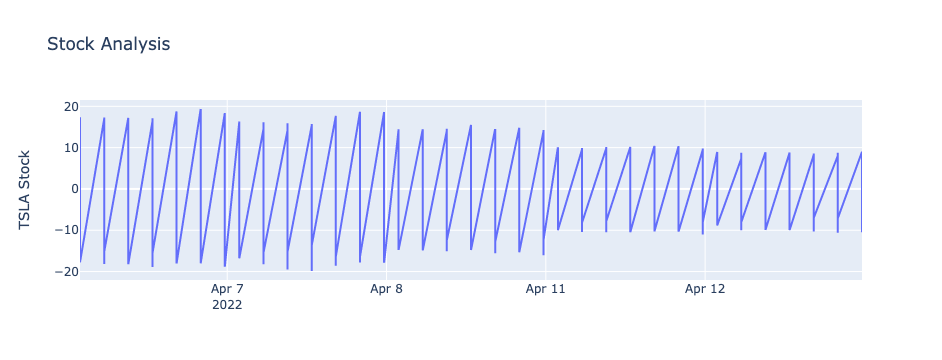

In [179]:
plot_line(df, value='beta', show_afterhours=False)

In [5]:

# for leg in self.legs:
leg_open = op.black_scholes(K=363.33, St=363.33, r=3, t=0.1, v=53, type='c')['value']['option value']
    # leg_close = op.black_scholes(
    #     K=candle[leg], St=candle['underlying_close'], r=3, t=candle['dte'], v=53, type=contract
    # )['value']['option value']
    # leg_open *= money_gained
    # leg_close *= money_gained

In [9]:
short_calls = np.array([op.black_scholes(K=363.33, St=st, r=3, t=0.1, v=53, type='c')['value']['option value'] for st in np.arange(300,400, 20)])
long_calls = np.array([op.black_scholes(K=370, St=st, r=3, t=0.1, v=53, type='c')['value']['option value'] for st in np.arange(300,400, 20)])

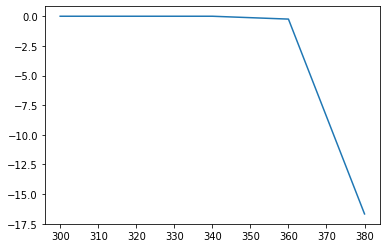

In [14]:
plt.plot(np.arange(300,400, 20), -short_calls)
# plt.plot(np.arange(300,400, 20), long_calls)

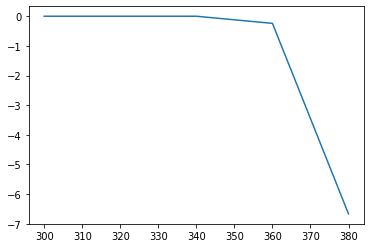

In [13]:
plt.plot(np.arange(300,400, 20), -short_calls+long_calls)

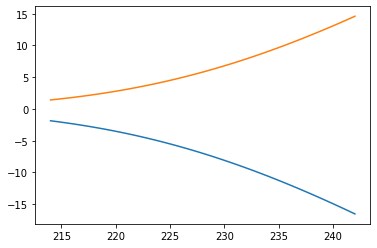

In [50]:
underlying = np.linspace(214,242,40)
short_calls = np.array([op.black_scholes(K=227.5, St=st, r=3, t=7, v=53, type='c')['value']['option value'] for st in underlying])
long_calls = np.array([op.black_scholes(K=230, St=st, r=3, t=7, v=53, type='c')['value']['option value'] for st in underlying])
plt.plot(underlying, -short_calls)
plt.plot(underlying, long_calls)

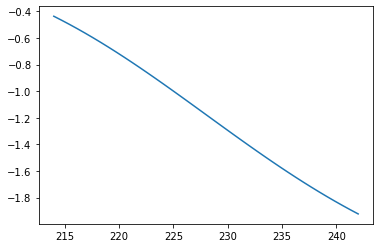

In [51]:
plt.plot(underlying, -short_calls+long_calls)

In [45]:
op.black_scholes(K=227.5, St=228, r=3, t=7, v=53, type='c')

{'value': {'option value': 6.98554898724143,
  'intrinsic value': 0.5,
  'time value': 6.48554898724143},
 'greeks': {'delta': 0.5296732204754231,
  'gamma': 0.02377350453571905,
  'theta': -0.48489695223345897,
  'vega': 0.12561570684388162,
  'rho': 0.02182081142378316}}

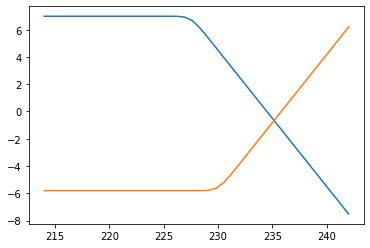

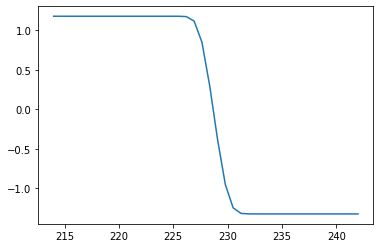

In [65]:
underlying = np.linspace(214,242,40)
initial_short = op.black_scholes(K=227.5, St=228, r=3, t=7, v=53, type='c')['value']['option value']
initial_long = op.black_scholes(K=230, St=228, r=3, t=7, v=53, type='c')['value']['option value']
underlying = np.linspace(214,242,40)
short_calls = -np.array([op.black_scholes(K=227.5, St=st, r=3, t=0.01, v=53, type='c')['value']['option value'] for st in underlying]) + initial_short
long_calls = np.array([op.black_scholes(K=230, St=st, r=3, t=0.01, v=53, type='c')['value']['option value'] for st in underlying]) - initial_long
plt.plot(underlying, short_calls)
plt.plot(underlying, long_calls)
plt.figure()
plt.plot(underlying, short_calls+long_calls)

In [57]:
initial_long, initial_short

(5.809433804546828, 6.98554898724143)

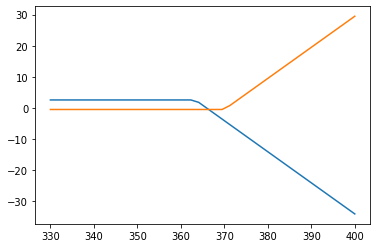

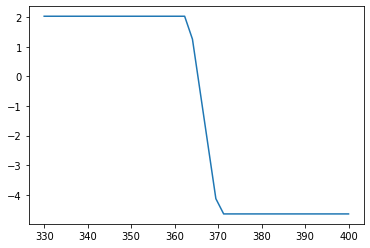

In [94]:
underlying = np.linspace(330,400,40)
v = 13

initial_short = op.black_scholes(K=363.33, St=363, r=3, t=7, v=v, type='c')['value']['option value']
initial_long = op.black_scholes(K=370, St=363, r=3, t=7, v=v, type='c')['value']['option value']
short_calls = -np.array([op.black_scholes(K=363.33, St=st, r=3, t=0.01, v=v, type='c')['value']['option value'] for st in underlying]) + initial_short
long_calls = np.array([op.black_scholes(K=370, St=st, r=3, t=0.01, v=v, type='c')['value']['option value'] for st in underlying]) - initial_long
plt.plot(underlying, short_calls)
plt.plot(underlying, long_calls)
plt.figure()
plt.plot(underlying, short_calls+long_calls)

In [97]:
np.diff(underlying)

array([1.79487179, 1.79487179, 1.79487179, 1.79487179, 1.79487179,
       1.79487179, 1.79487179, 1.79487179, 1.79487179, 1.79487179,
       1.79487179, 1.79487179, 1.79487179, 1.79487179, 1.79487179,
       1.79487179, 1.79487179, 1.79487179, 1.79487179, 1.79487179,
       1.79487179, 1.79487179, 1.79487179, 1.79487179, 1.79487179,
       1.79487179, 1.79487179, 1.79487179, 1.79487179, 1.79487179,
       1.79487179, 1.79487179, 1.79487179, 1.79487179, 1.79487179,
       1.79487179, 1.79487179, 1.79487179, 1.79487179])

In [98]:
np.diff(short_calls)/1.79487179

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -5.24401486e-07, -4.30628350e-01, -9.99966079e-01,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00])

In [99]:
np.diff(long_calls)/1.79487179

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00107696, 0.71337819, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [91]:
op.black_scholes(K=363.33, St=371, r=3, t=0.1, v=v, type='c'), op.black_scholes(K=370, St=371, r=3, t=0.1, v=v, type='c')

({'value': {'option value': 7.6729862617002595,
   'intrinsic value': 7.670000000000016,
   'time value': 0.002986261700243631},
  'greeks': {'delta': 1.0,
   'gamma': 1.6248274251840382e-21,
   'theta': -0.02986249427986025,
   'vega': 7.9653625511968e-23,
   'rho': 0.000995416475995342}},
 {'value': {'option value': 1.0426879692822126,
   'intrinsic value': 1,
   'time value': 0.042687969282212634},
  'greeks': {'delta': 0.8960273047429947,
   'gamma': 0.22615940649231012,
   'theta': -0.7478901953584363,
   'vega': 0.011086972309509724,
   'rho': 0.0009078998413434763}})

In [82]:
v = 13
initial_short = op.black_scholes(K=363.33, St=363, r=3, t=7, v=v, type='c')['value']['option value']
initial_long = op.black_scholes(K=370, St=363, r=3, t=7, v=v, type='c')['value']['option value']
short_calls = -op.black_scholes(K=363.33, St=371, r=3, t=0.01, v=v, type='c')['value']['option value'] + initial_short
long_calls = op.black_scholes(K=370, St=371, r=3, t=0.01, v=v, type='c')['value']['option value'] - initial_long
short_calls, long_calls, long_calls+short_calls

(-5.12283311643364, 0.480444086383379, -4.642389030050261)

In [114]:
v = 13

[-1.01013018 -1.00488626]
[-1.00372314 -0.99506412]
[-1.01165948 -1.00603443]
[-1.01899686 -1.01772544]
[-1.02013451 -1.01985373]
[-1.0203502  -1.02034388]
[-1.02038021 -1.02038021]


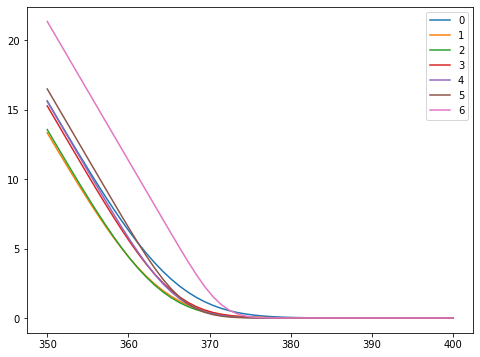

In [118]:
underlying = [365.536630113, 363.243297009,  363.49996365, 365.226630144, 365.559963444,
  366.46663002,   371.3332962]

def compare_chain_prices(start, expiration):
    strikes = np.linspace(350,400,50)
    plt.figure(figsize=(8,6))
    for i, u in zip(range(7), underlying):
        # opens = [qbw.option_history(s, datetime(*start), start=datetime(*expiration)).iloc[i]['close'] for s in strikes]
        opens = [op.black_scholes(K=s, St=u, r=3, t=7-i, v=v, type='c')['value']['option value'] for s in strikes]
        print(np.diff(opens[:3]))
        plt.plot(strikes, opens, label=f'{i}')
    plt.legend()
compare_chain_prices((2021, 10, 29), (2021, 10, 29))

[-0.00388497 -0.00560389 -0.00786837 -0.01075652 -0.01432024 -0.01857024
 -0.02346228 -0.02888709 -0.03466674 -0.04055939 -0.04627344 -0.05149035
 -0.05589389 -0.0592021  -0.06119743 -0.06175051 -0.060834   -0.05852439
 -0.05499174]
[-0.00652068 -0.00935516 -0.01300886 -0.01753771 -0.02292802 -0.02907593
 -0.03577554 -0.04272039 -0.04952114 -0.05573923 -0.06093319 -0.06471067
 -0.06677783 -0.06697727 -0.06530771 -0.06192209 -0.05710472 -0.0512323
 -0.04472601]
[-0.00405123 -0.00629676 -0.00942676 -0.01359758 -0.0189039  -0.02533775
 -0.03275259 -0.04084299 -0.04914905 -0.05709117 -0.06403359 -0.06936804
 -0.07260224 -0.07343527 -0.07180377 -0.0678891  -0.06208468 -0.05493137
 -0.04703562]
[-0.00081996 -0.00153036 -0.00272498 -0.00463102 -0.00751456 -0.01164706
 -0.01724971 -0.02442121 -0.0330626  -0.04282076 -0.05307384 -0.06297604
 -0.07156435 -0.07791144 -0.08129123 -0.08131626 -0.07801067 -0.07179988
 -0.06342131]
[-0.00015917 -0.00037192 -0.00081622 -0.00168332 -0.00326411 -0.00595

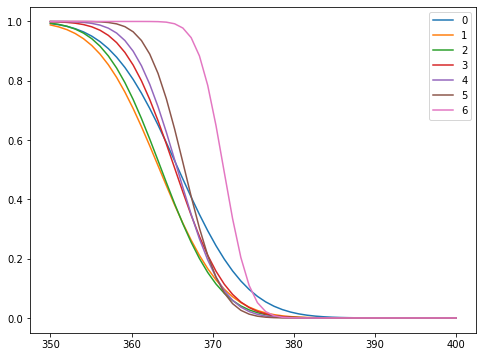

In [110]:
underlying = [365.536630113, 363.243297009,  363.49996365, 365.226630144, 365.559963444,
  366.46663002,   371.3332962]
def compare_chain_prices(start, expiration):
    strikes = np.linspace(350,400,50)
    plt.figure(figsize=(8,6))
    for i, u in zip(range(7), underlying):
        # opens = [qbw.option_history(s, datetime(*start), start=datetime(*expiration)).iloc[i]['close'] for s in strikes]
        opens = [op.black_scholes(K=s, St=u, r=3, t=7-i, v=v, type='c')['greeks']['delta'] for s in strikes]
        print(np.diff(opens[:20]))
        plt.plot(strikes, opens, label=f'{i}')
    plt.legend()
compare_chain_prices((2021, 10, 29), (2021, 10, 29))

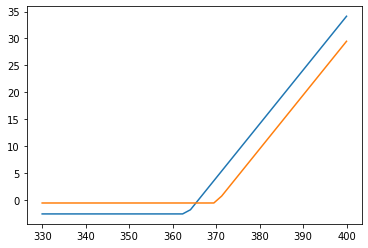

In [119]:
underlying = np.linspace(330,400,40)
v = 13

initial_short = op.black_scholes(K=363.33, St=363, r=3, t=7, v=v, type='c')['value']['option value']
initial_long = op.black_scholes(K=370, St=363, r=3, t=7, v=v, type='c')['value']['option value']
short_calls = -np.array([op.black_scholes(K=363.33, St=st, r=3, t=0.01, v=v, type='c')['value']['option value'] for st in underlying]) + initial_short
long_calls = np.array([op.black_scholes(K=370, St=st, r=3, t=0.01, v=v, type='c')['value']['option value'] for st in underlying]) - initial_long
plt.plot(underlying, -short_calls)
plt.plot(underlying, long_calls)
# plt.figure()
# plt.plot(underlying, short_calls+long_calls)

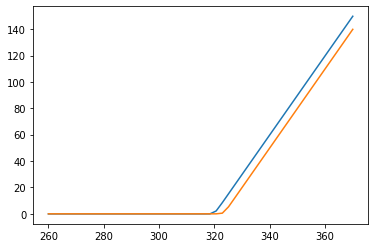

In [125]:
underlying = np.linspace(260,370,50)
v = 53
r = 10

initial_short = op.black_scholes(K=320, St=268, r=r, t=7, v=v, type='c')['value']['option value']
initial_long = op.black_scholes(K=323.33, St=268, r=r, t=7, v=v, type='c')['value']['option value']
short_calls = -np.array([op.black_scholes(K=320, St=st, r=r, t=0.01, v=v, type='c')['value']['option value'] for st in underlying]) + initial_short
long_calls = np.array([op.black_scholes(K=323.33, St=st, r=r, t=0.01, v=v, type='c')['value']['option value'] for st in underlying]) - initial_long
plt.plot(underlying, -short_calls*3)
plt.plot(underlying, long_calls*3)
# plt.figure()
# plt.plot(underlying, short_calls+long_calls)